In [1]:
import geowombat as gw
from geowombat.data import l8_224078_20200518, l8_224078_20200518_polygons
from geowombat.ml import fit, predict, fit_predict
import geopandas as gpd
from sklearn_xarray.preprocessing import Featurizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB

le = LabelEncoder()

# The labels are string names, so here we convert them to integers
labels = gpd.read_file(l8_224078_20200518_polygons)
labels['lc'] = le.fit(labels.name).transform(labels.name)
print(labels)

        name                                           geometry  lc
0      water  POLYGON ((737544.502 -2795232.772, 737544.502 ...   3
1       crop  POLYGON ((742517.658 -2798160.232, 743046.717 ...   0
2       tree  POLYGON ((742435.360 -2801875.403, 742458.874 ...   2
3  developed  POLYGON ((738903.667 -2811573.845, 738926.586 ...   1


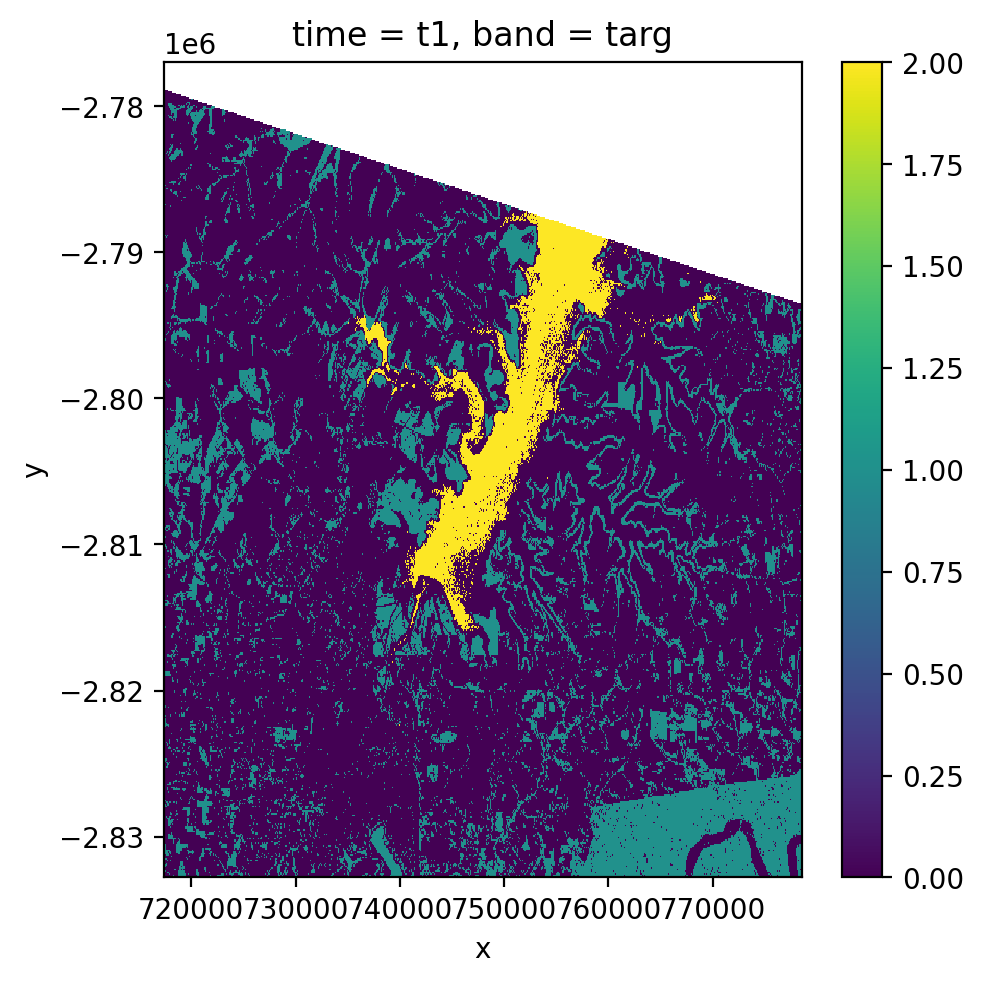

In [2]:
import matplotlib.pyplot as plt

# Use a data pipeline
pl = Pipeline([ ('scaler', StandardScaler()),
                ('pca', PCA()),
                ('clf', GaussianNB())])

fig, ax = plt.subplots(dpi=200,figsize=(5,5))

# Fit the classifier
with gw.config.update(ref_res=100):
    with gw.open(l8_224078_20200518) as src:
        X, Xy, clf = fit(src, pl, labels, col="lc")
        y = predict(src, X, clf)
        y.plot(robust=True, ax=ax)
plt.tight_layout(pad=1)

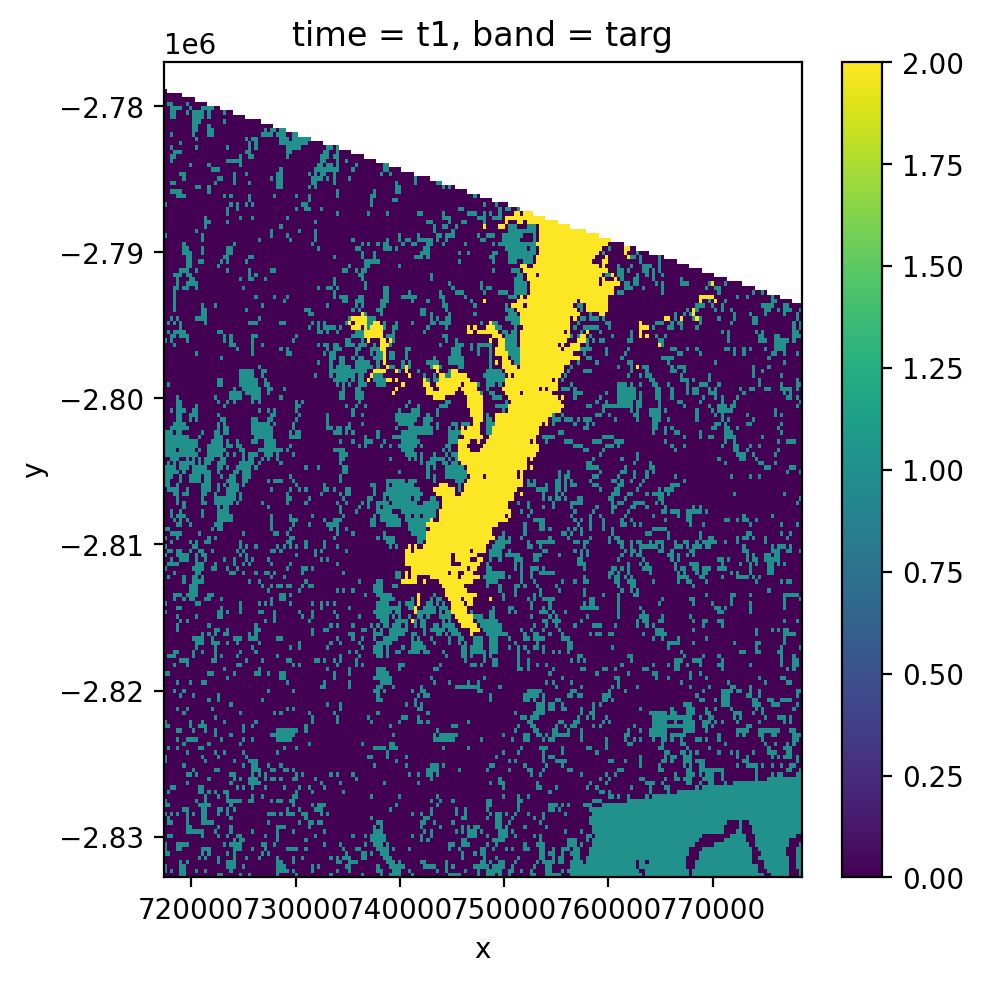

In [3]:
from geowombat.ml import fit_predict
fig, ax = plt.subplots(dpi=200,figsize=(5,5))

with gw.config.update(ref_res=300):
    with gw.open(l8_224078_20200518) as src:
        y = fit_predict(src, pl, labels, col='lc')
        y.plot(robust=True, ax=ax)
plt.tight_layout(pad=1)


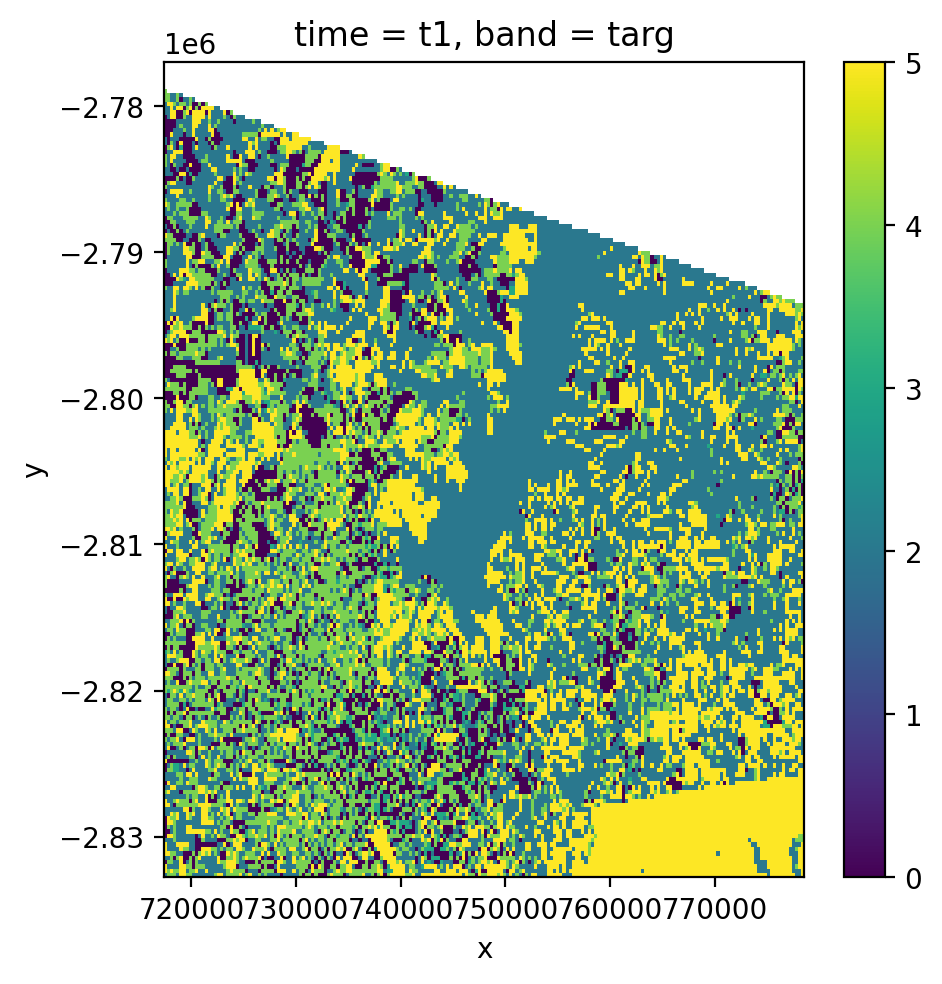

In [4]:
from sklearn.cluster import KMeans
cl = Pipeline([ ('clf', KMeans(n_clusters=6, random_state=0))])

fig, ax = plt.subplots(dpi=200,figsize=(5,5))

# Fit_predict unsupervised classifier
with gw.config.update(ref_res=300):
    with gw.open(l8_224078_20200518) as src:
        y= fit_predict(src, cl)
        y.plot(robust=True, ax=ax)
plt.tight_layout(pad=1)

<xarray.DataArray (time: 2, y: 558, x: 612)>
dask.array<getitem, shape=(2, 558, 612), dtype=float64, chunksize=(1, 256, 256), chunktype=numpy.ndarray>
Coordinates:
    band     <U4 'targ'
  * y        (y) float64 -2.777e+06 -2.777e+06 ... -2.833e+06 -2.833e+06
  * x        (x) float64 7.174e+05 7.175e+05 7.176e+05 ... 7.784e+05 7.785e+05
  * time     (time) <U2 't1' 't2'
    targ     (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    transform:          (100.0, 0.0, 717345.0, 0.0, -100.0, -2776995.0)
    crs:                +init=epsg:32621
    res:                (100.0, 100.0)
    is_tiled:           1
    nodatavals:         (0, 0, 0)
    scales:             (1.0, 1.0, 1.0)
    offsets:            (0.0, 0.0, 0.0)
    filename:           ['LC08_L1TP_224078_20200518_20200518_01_RT.TIF', 'LC0...
    resampling:         nearest
    AREA_OR_POINT:      Area
    data_are_separate:  1
    data_are_stacked:   1


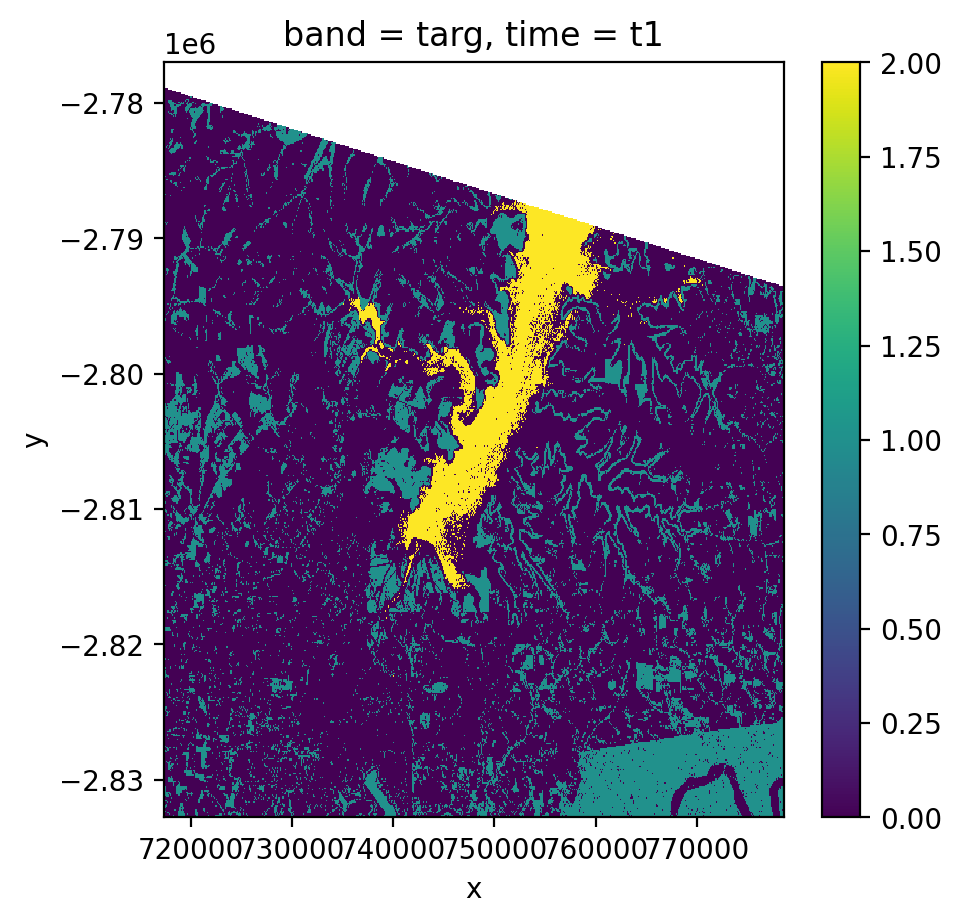

In [5]:
fig, ax = plt.subplots(dpi=200,figsize=(5,5))

with gw.config.update(ref_res=100):
   with gw.open([l8_224078_20200518, l8_224078_20200518], time_names=['t1', 't2'], stack_dim='time') as src:
        y = fit_predict(src, pl, labels, col='lc')
        print(y)
        # plot one time period prediction
        y.sel(time='t1').plot(robust=True, ax=ax)

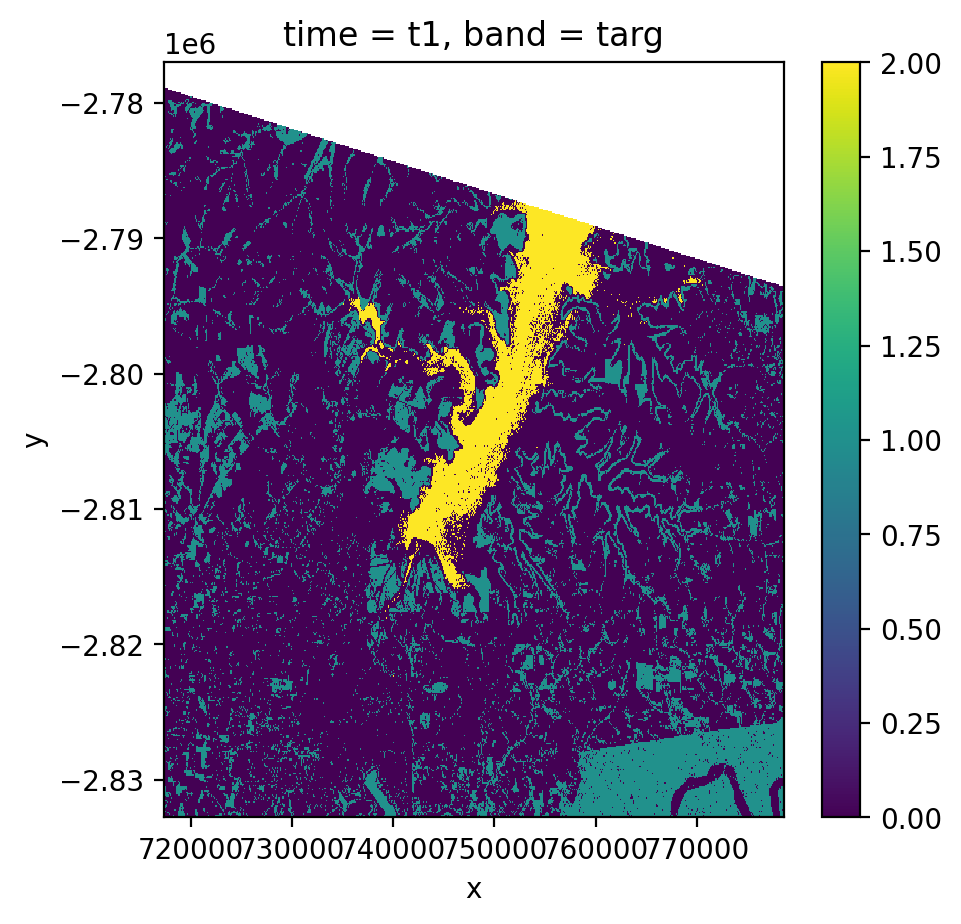

In [6]:
fig, ax = plt.subplots(dpi=200,figsize=(5,5))

with gw.config.update(ref_res=100):
    with gw.open(l8_224078_20200518) as src:
        X, Xy, clf = fit(src, pl, labels, col="lc")
        y = predict(src, X, clf)
        y.plot(robust=True, ax=ax)

{'mean_fit_time': array([0.0675138 , 0.09112916, 0.10465975, 0.09694691, 0.11138215,
       0.10502863]), 'std_fit_time': array([0.0026861 , 0.0170154 , 0.02087737, 0.0155686 , 0.00644429,
       0.01034582]), 'mean_score_time': array([0.04769511, 0.06442866, 0.06269984, 0.0667346 , 0.06374388,
       0.06502442]), 'std_score_time': array([0.00725112, 0.01721732, 0.01106937, 0.0115618 , 0.01124299,
       0.00674123]), 'param_pca__n_components': masked_array(data=[1, 1, 2, 2, 3, 3],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_scaler__with_std': masked_array(data=[True, False, True, False, True, False],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'pca__n_components': 1, 'scaler__with_std': True}, {'pca__n_components': 1, 'scaler__with_std': False}, {'pca__n_components': 2, 'scaler__with_std': True}, {'pca__n_components': 2, 'scaler__w

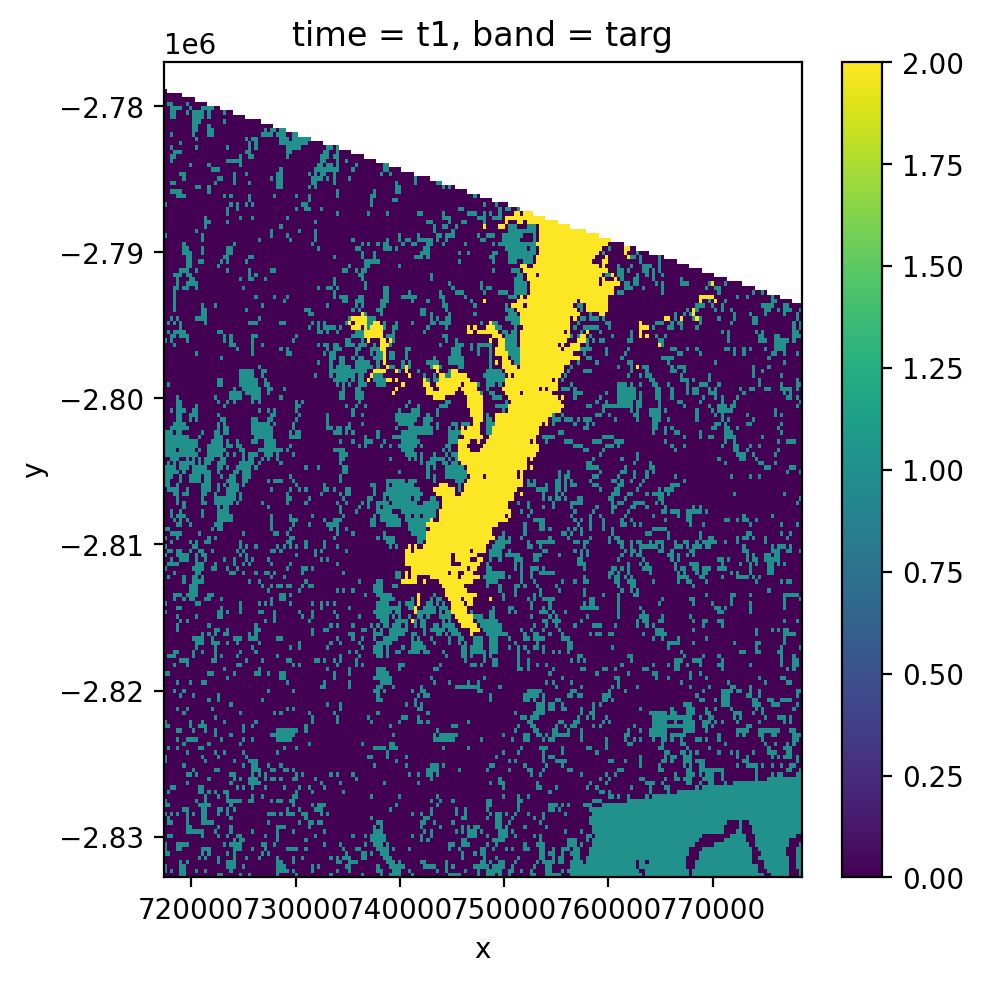

In [7]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn_xarray.model_selection import CrossValidatorWrapper

pl = Pipeline([('scaler', StandardScaler()),
               ('pca', PCA()),
               ('clf', GaussianNB())])

cv = CrossValidatorWrapper(KFold())
gridsearch = GridSearchCV(pl, cv=cv, scoring='balanced_accuracy',
                    param_grid={
                      "scaler__with_std":[True,False],
                      "pca__n_components": [1, 2, 3]
                      })

fig, ax = plt.subplots(dpi=200,figsize=(5,5))

with gw.config.update(ref_res=300):
    with gw.open(l8_224078_20200518) as src:
        # fit a model to get Xy used to train model
        X, Xy, pipe = fit(src, pl, labels, col="lc")

        # fit cross valiation and parameter tuning
        # NOTE: must unpack * object Xy
        gridsearch.fit(*Xy)
        print(gridsearch.cv_results_)
        print(gridsearch.best_score_)
        print(gridsearch.best_params_)        

        # get set tuned parameters and make the prediction
        # Note: predict(gridsearch.best_model_) not currently supported
        pipe.set_params(**gridsearch.best_params_)
        y = predict(src, X, pipe)
        y.plot(robust=True, ax=ax)
plt.tight_layout(pad=1)